NVIDIA Tesla A100 SXM4 40 GB, 6912 CUDA cores
CUDA Version: 12.2

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Apr 15 19:14:09 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0              43W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install transformers
!pip install datasets
!pip install tensorflow_text
!pip install nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 33.8 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset
import pandas as pd
import tensorflow as tf
import numpy as np
import tensorflow_hub as hub
import tensorflow_text as text
from keras import backend as K
from sklearn.metrics import classification_report, confusion_matrix
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
pd.set_option('display.max_colwidth', 500)
pd.set_option('display.max_rows', 25000)
from nltk.corpus import wordnet
nltk.download('averaged_perceptron_tagger')
from collections import Counter

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
lex_glue_ledgar_train = load_dataset("lex_glue",'ledgar',split='train')
lex_glue_ledgar_val = load_dataset("lex_glue",'ledgar',split='validation')
lex_glue_ledgar_test = load_dataset("lex_glue",'ledgar',split='test')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
clause_df_train = pd.DataFrame()
clause_df_validation = pd.DataFrame()
clause_df_test = pd.DataFrame()

clause_df_train["clause"] = lex_glue_ledgar_train["text"]
clause_df_train["label"] = lex_glue_ledgar_train["label"]

clause_df_validation["clause"] = lex_glue_ledgar_val["text"]
clause_df_validation["label"] = lex_glue_ledgar_val["label"]

clause_df_test["clause"] = lex_glue_ledgar_test["text"]
clause_df_test["label"] = lex_glue_ledgar_test["label"]


In [ ]:
print(clause_df_train.shape)
print(clause_df_validation.shape)
print(clause_df_test.shape)

(60000, 2)
(10000, 2)
(10000, 2)


In [ ]:
labels = ["Adjustments","Agreements","Amendments","Anti-Corruption Laws","Applicable Laws","Approvals","Arbitration","Assignments","Assigns","Authority","Authorizations","Base Salary","Benefits","Binding Effects","Books","Brokers","Capitalization","Change In Control","Closings","Compliance With Laws","Confidentiality","Consent To Jurisdiction","Consents","Construction","Cooperation","Costs","Counterparts","Death","Defined Terms","Definitions","Disability","Disclosures","Duties","Effective Dates","Effectiveness","Employment","Enforceability","Enforcements","Entire Agreements","Erisa","Existence","Expenses","Fees","Financial Statements","Forfeitures","Further Assurances","General","Governing Laws","Headings","Indemnifications","Indemnity","Insurances","Integration","Intellectual Property","Interests","Interpretations","Jurisdictions","Liens","Litigations","Miscellaneous","Modifications","No Conflicts","No Defaults","No Waivers","Non-Disparagement","Notices","Organizations","Participations","Payments","Positions","Powers","Publicity","Qualifications","Records","Releases","Remedies","Representations","Sales","Sanctions","Severability","Solvency","Specific Performance","Submission To Jurisdiction","Subsidiaries","Successors","Survival","Tax Withholdings","Taxes","Terminations","Terms","Titles","Transactions With Affiliates","Use Of Proceeds","Vacations","Venues","Vesting","Waiver Of Jury Trials","Waivers","Warranties","Withholdings"]

In [ ]:
labels_idx = [a for a in range(0,100)]

In [ ]:
labels_dict = {labels_idx[i]: labels[i] for i in range(len(labels_idx))}

In [ ]:
frames = [clause_df_train,clause_df_validation,clause_df_test]
all_df  = pd.concat(frames)
all_df.shape

(80000, 2)

In [ ]:
all_df['category'] = all_df['label'].map(labels_dict)

In [ ]:
all_df['clause_len'] = all_df['clause'].str.len()

In [ ]:
all_df.head()

,clause,label,category,clause_len
0,"Except as otherwise set forth in this Debenture, the Company, for itself and its legal representatives, successors and assigns, expressly waives presentment, protest, demand, notice of dishonor, notice of nonpayment, notice of maturity, notice of protest, presentment for the purpose of accelerating maturity, and diligence in collection.",97,Waivers,338
1,"No ERISA Event has occurred or is reasonably expected to occur that, when taken together with all other such ERISA Events for which liability is reasonably expected to occur, could reasonably be expected to result in a Material Adverse Effect. Neither Borrower nor any ERISA Affiliate maintains or contributes to or has any obligation to maintain or contribute to any Multiemployer Plan or Plan, nor otherwise has any liability under Title IV of ERISA.",39,Erisa,452
2,"This Amendment may be executed by one or more of the parties hereto on any number of separate counterparts, and all of said counterparts taken together shall be deemed to constitute one and the same instrument. This Amendment may be delivered by facsimile or other electronic transmission of the relevant signature pages hereof.",26,Counterparts,328
3,"From time to time, as and when required by the Surviving Corporation or by its successors or assigns, there shall be executed and delivered on behalf of Ashford (DE) such deeds and other instruments, and there shall be taken or caused to be taken by it all such further and other action, as shall be appropriate, advisable or necessary in order to vest, perfect or confirm, of record or otherwise, in the Surviving Corporation the title to and possession of all property, interests, assets, right...",45,Further Assurances,870
4,"Commencing March 7, 2016 and during the Employment Period, the Company shall pay to the Executive a base salary at the rate of no less than $750,000 per calendar year (the “Base Salary”), less applicable deductions, and prorated for any partial month or year, as applicable. The Base Salary shall be reviewed for increase by the Compensation Committees of AFG and AAC (the “Compensation Committees”) no less frequently than annually and may be increased in the discretion of the Compensation Comm...",11,Base Salary,1286


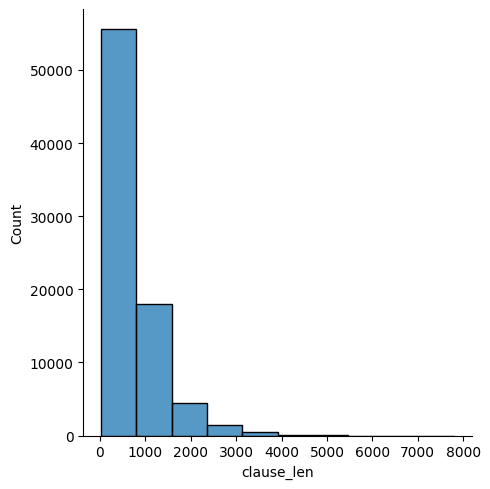

In [ ]:
sns.displot(all_df['clause_len'], bins=10)

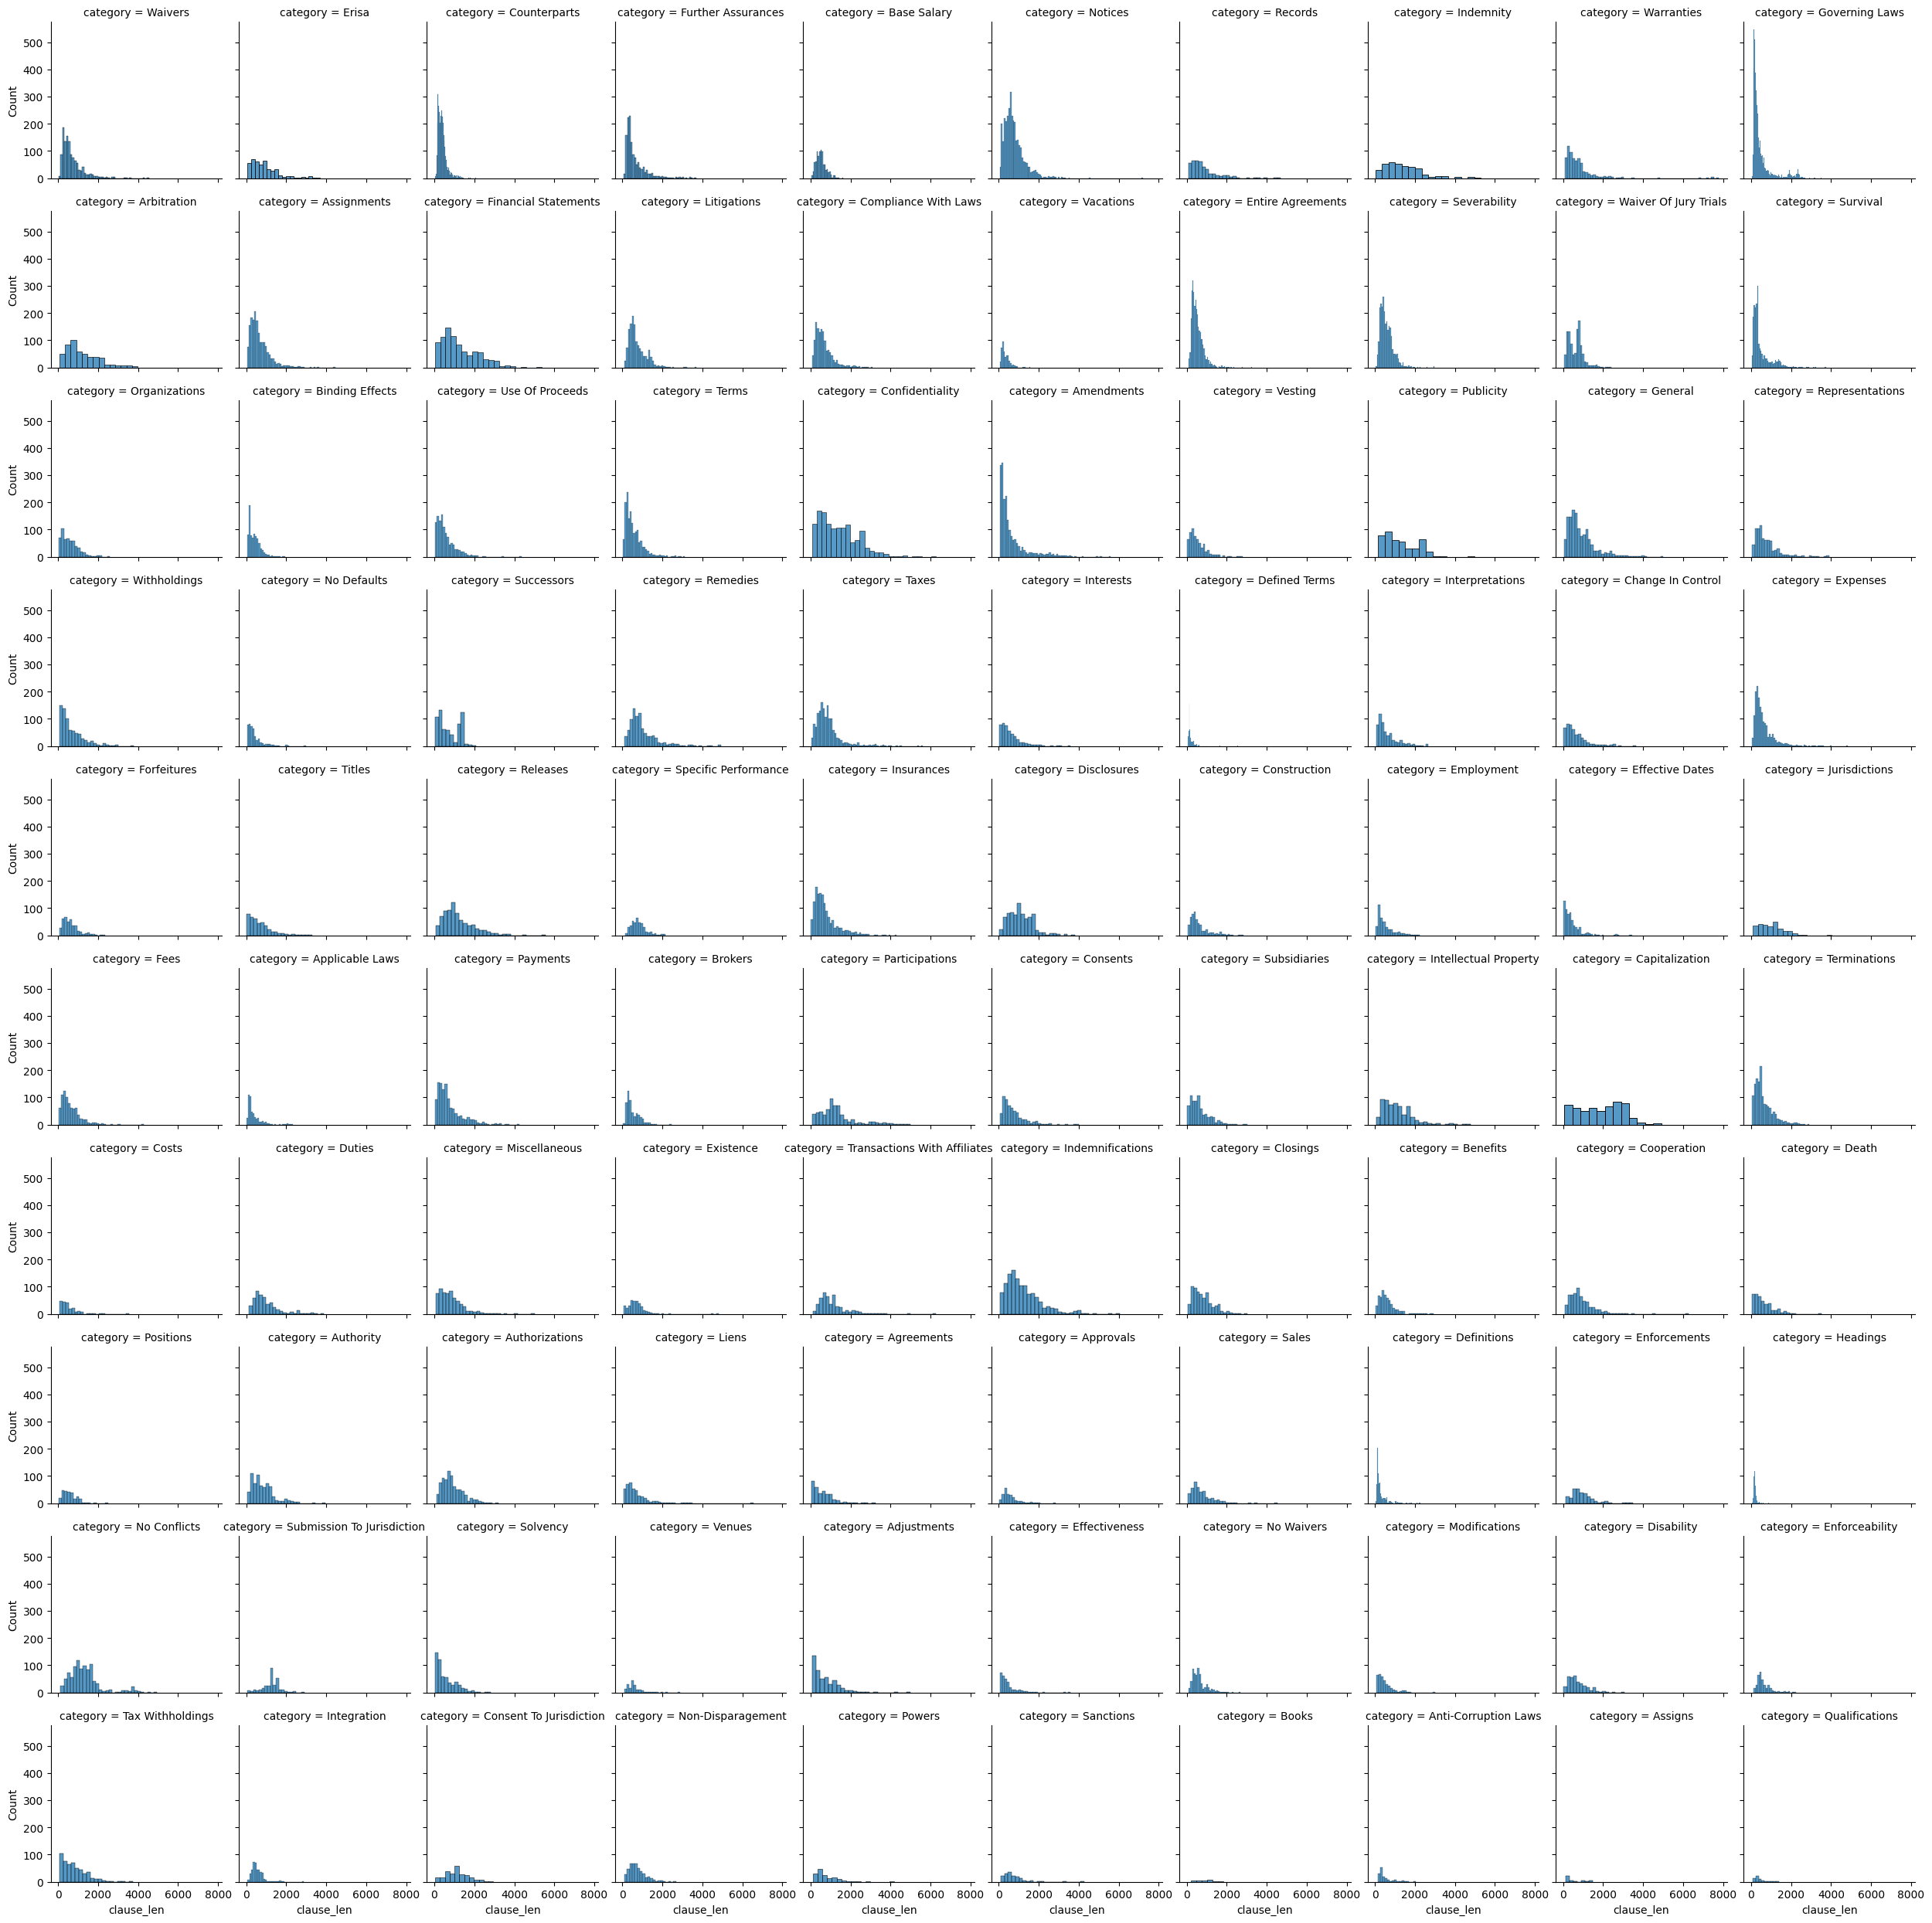

In [ ]:
g = sns.FacetGrid(all_df, col='category', height=2.5, col_wrap=10)
p1 = g.map(sns.histplot, 'clause_len')

In [ ]:
all_df.groupby(['label','category']).count().reset_index()[['category','clause']].sort_values(by='clause', ascending=False)

In [ ]:
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    return tag_dict.get(tag,
                        wordnet.NOUN) # Default if no match

lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word,get_wordnet_pos(word)) for word in text.split()])

In [ ]:
## Test preprocessing

# Lower Case

clause_df_train["clause"] = clause_df_train["clause"].str.lower()
clause_df_validation["clause"] = clause_df_validation["clause"].str.lower()
clause_df_test["clause"] = clause_df_test["clause"].str.lower()

# # lemmatize # Takes 30 minutes

# clause_df_train["clause"] = clause_df_train["clause"].apply(lambda text: lemmatize_words(text))
# clause_df_validation["clause"] = clause_df_validation["clause"].apply(lambda text: lemmatize_words(text))
# clause_df_test["clause"] = clause_df_test["clause"].apply(lambda text: lemmatize_words(text))

# Removal of Punctuations

clause_df_train["clause"] = clause_df_train["clause"].apply(lambda text: remove_punctuation(text))
clause_df_validation["clause"] = clause_df_validation["clause"].apply(lambda text: remove_punctuation(text))
clause_df_test["clause"] = clause_df_test["clause"].apply(lambda text: remove_punctuation(text))

# Removal of stopwords

clause_df_train["clause"] = clause_df_train["clause"].apply(lambda text: remove_stopwords(text))
clause_df_validation["clause"] = clause_df_validation["clause"].apply(lambda text: remove_stopwords(text))
clause_df_test["clause"] = clause_df_test["clause"].apply(lambda text: remove_stopwords(text))

In [ ]:
import numpy as np
from contextlib import contextmanager

@contextmanager
def show_complete_array():
    oldoptions = np.get_printoptions()
    np.set_printoptions(threshold=np.inf)
    try:
        yield
    finally:
        np.set_printoptions(**oldoptions)

In [ ]:
TOP_N_MOST_COMMON_LIMIT = 100

In [ ]:
np.sort(np.unique(clause_df_train.label))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [ ]:
top_words = []
for i in range(100):
  top_words.append(Counter(" ".join(clause_df_train[clause_df_train.label==i]["clause"]).split()).most_common(100))

In [ ]:
with show_complete_array():
    print(top_words)  # shows the complete array

[[('stock', 625), ('shall', 557), ('shares', 533), ('section', 323), ('number', 306), ('plan', 301), ('event', 249), ('adjustment', 234), ('subject', 233), ('company', 227), ('common', 215), ('lender', 212), ('may', 190), ('dividend', 185), ('committee', 175), ('award', 166), ('securities', 160), ('change', 160), ('made', 154), ('provided', 150), ('payment', 150), ('respect', 148), ('cash', 147), ('split', 147), ('outstanding', 139), ('agreement', 138), ('price', 132), ('benefits', 125), ('pursuant', 123), ('share', 119), ('including', 112), ('adjustments', 111), ('purchase', 110), ('performance', 108), ('adjusted', 104), ('merger', 97), ('units', 97), ('consolidation', 95), ('recapitalization', 91), ('reorganization', 88), ('class', 88), ('amount', 86), ('events', 82), ('applicable', 82), ('rights', 81), ('combination', 79), ('distribution', 78), ('spinoff', 78), ('option', 78), ('participant', 77), ('awards', 77), ('without', 77), ('time', 77), ('provisions', 77), ('terms', 76), ('si

In [ ]:
len(top_words)

100

In [ ]:
def retain_top_words(row):
    """custom function to reatin the top words only"""
    clause = row['clause']
    label = row['label']
    top_words_for_that_label = [word[0] for word in top_words[label]]
    lst = " ".join([word for word in str(clause).split() if word in top_words_for_that_label])
    unique_keys = Counter(lst.split(" "))
    res = " ".join(unique_keys.keys())
    return res

In [ ]:
# clause_df_train[0:5].apply(retain_top_words,axis=1)

In [ ]:
clause_df_train["clause"] = clause_df_train.apply(retain_top_words,axis=1)
clause_df_validation["clause"] = clause_df_validation.apply(retain_top_words,axis=1)
clause_df_test["clause"] = clause_df_test.apply(retain_top_words,axis=1)

In [ ]:
clause_df_train[0:5]

,clause,label
0,except otherwise set forth company expressly waives demand notice,97
1,erisa event occurred reasonably expected occur taken together events liability could result material adverse effect neither borrower affiliate multiemployer plan title iv,39
2,amendment may executed one parties hereto number separate counterparts said taken together shall deemed constitute instrument delivered facsimile electronic transmission signature pages hereof,26
3,time required shall executed delivered instruments action appropriate necessary order perfect otherwise interests assets rights carry purposes agreement fully take execute deliver,45
4,employment period company shall pay executive base salary rate less per year “base salary” applicable deductions month reviewed increase compensation frequently annually may increased discretion adjusted purposes agreement paid equal installments accordance regular payroll procedures executive’s decreased amount section effective date payable,11


In [ ]:
# # Lemmatization

# clause_df_train["clause"] = clause_df_train["clause"].apply(lambda text: lemmatize_words(text))
# clause_df_validation["clause"] = clause_df_validation["clause"].apply(lambda text: lemmatize_words(text))
# clause_df_test["clause"] = clause_df_test["clause"].apply(lambda text: lemmatize_words(text))

In [ ]:
# print(len(np.unique(clause_df_train["label"].values)));
# print(len(np.unique(clause_df_test["label"].values)));
# print(len(np.unique(clause_df_validation["label"].values)));

In [ ]:
# will use this for train, val and test
num_classes = len(np.unique(clause_df_train["label"]))
num_classes

100

In [ ]:
clause_df_train["label"] = tf.keras.utils.to_categorical(lex_glue_ledgar_train["label"], num_classes = num_classes).tolist()
clause_df_validation["label"] = tf.keras.utils.to_categorical(lex_glue_ledgar_val["label"], num_classes = num_classes).tolist()
clause_df_test["label"] = tf.keras.utils.to_categorical(lex_glue_ledgar_test["label"], num_classes = num_classes).tolist()

In [ ]:
clause_df_train["label"][0:5]

0    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...
1    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

***https://tfhub.dev/google/collections/bert/1***

The following models in the SavedModel format of TensorFlow 2 use the implementation of BERT from the TensorFlow Models repository on GitHub at tensorflow/models/official/legacy/bert with the trained weights released by the original BERT authors.

These SavedModels implement the encoder API for text embeddings with transformer encoders. Plain text input can be fed to them models via the separate preprocessing model referenced in the second column.

In [ ]:
preprocessor =  hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
encoder = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-cmlm/en-large/1")

In [ ]:
def get_embeddings(sentences):
  '''return BERT-like embeddings of input text
  Args:
    - sentences: list of strings
  Output:
    - BERT-like embeddings: tf.Tensor of shape=(len(sentences), 768)
  '''
  preprocessed_text = preprocessor(sentences)
  return encoder(preprocessed_text)['pooled_output']

In [ ]:
get_embeddings([clause_df_train['clause'][0]])[0:10]

<tf.Tensor: shape=(1, 1024), dtype=float32, numpy=
array([[-0.6051591 , -0.20530112,  1.0771166 , ..., -1.0692788 ,
        -1.2840537 ,  0.5019407 ]], dtype=float32)>

In [ ]:
def balanced_recall(y_true, y_pred):
    """This function calculates the balanced recall metric
    recall = TP / (TP + FN)
    """
    recall_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true_class, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        recall_by_class = recall_by_class + recall
    return recall_by_class / y_pred.shape[1]

def balanced_precision(y_true, y_pred):
    """This function calculates the balanced precision metric
    precision = TP / (TP + FP)
    """
    precision_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred_class, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        precision_by_class = precision_by_class + precision
    # return average balanced metric for each class
    return precision_by_class / y_pred.shape[1]

def balanced_f1_score(y_true, y_pred):
    """This function calculates the F1 score metric"""
    precision = balanced_precision(y_true, y_pred)
    recall = balanced_recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [ ]:
i = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
x = preprocessor(i)
x = encoder(x)
x = tf.keras.layers.Dropout(0.2, name="dropout")(x['pooled_output'])
x = tf.keras.layers.Dense(num_classes, activation='softmax', name="output")(x)

model = tf.keras.Model(i, x)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_mask': (None, 128)   0         ['text[0][0]']                
                             , 'input_word_ids': (None,                                           
                              128),                                                               
                              'input_type_ids': (None,                                            
                             128)}                                                                
                                                                                              

In [ ]:
x_train = np.array([np.array(val) for val in clause_df_train['clause']])
y_train = np.array([np.array(val) for val in clause_df_train['label']])

x_val = np.array([np.array(val) for val in clause_df_validation['clause']])
y_val = np.array([np.array(val) for val in clause_df_validation['label']])

x_test = np.array([np.array(val) for val in clause_df_test['clause']])
y_test = np.array([np.array(val) for val in clause_df_test['label']])

In [ ]:
print("Training start at: ",datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

Training start at:  2023-10-21 19:26:54


In [ ]:
# n_epochs = 20 # Initial run but found little benefit after 12 so setting as 15 for subsequent runs

n_epochs = 5

METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
      balanced_recall,
      balanced_precision,
      balanced_f1_score
]

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",
                                                      patience = 3,
                                                      restore_best_weights = True)

model.compile(optimizer = "adam",
              loss = "categorical_crossentropy",
              metrics = METRICS)

# model_fit = model.fit(x_train,
#                       y_train,
#                       epochs = n_epochs,
#                       validation_data = (x_val, y_val),
#                       callbacks = [earlystop_callback])

In [ ]:
training_args = TrainingArguments(output_dir='training_dir',
                                  evaluation_strategy='epoch',
                                  save_strategy='epoch',
                                  num_train_epochs=5,
                                  per_device_train_batch_size=8,
                                  per_device_eval_batch_size=8,
                                  )

In [ ]:
def compute_metrics(logits_and_labels):
  logits, labels = logits_and_labels
  predictions = np.argmax(logits, axis=-1)
  acc = np.mean(predictions == labels)
  f1 = f1_score(labels, predictions, average = 'micro')
  return {'accuracy': acc, 'f1_score': f1}

In [ ]:
trainer = Trainer(model,
                  training_args,
                  train_dataset = tokenized_dataset["train"],
                  eval_dataset = tokenized_dataset["validation"],
                  tokenizer=tokenizer,
                  compute_metrics=compute_metrics)

In [ ]:
trainer.train()

In [ ]:
print("Training end at: ",datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

Training end at:  2023-10-18 08:43:04


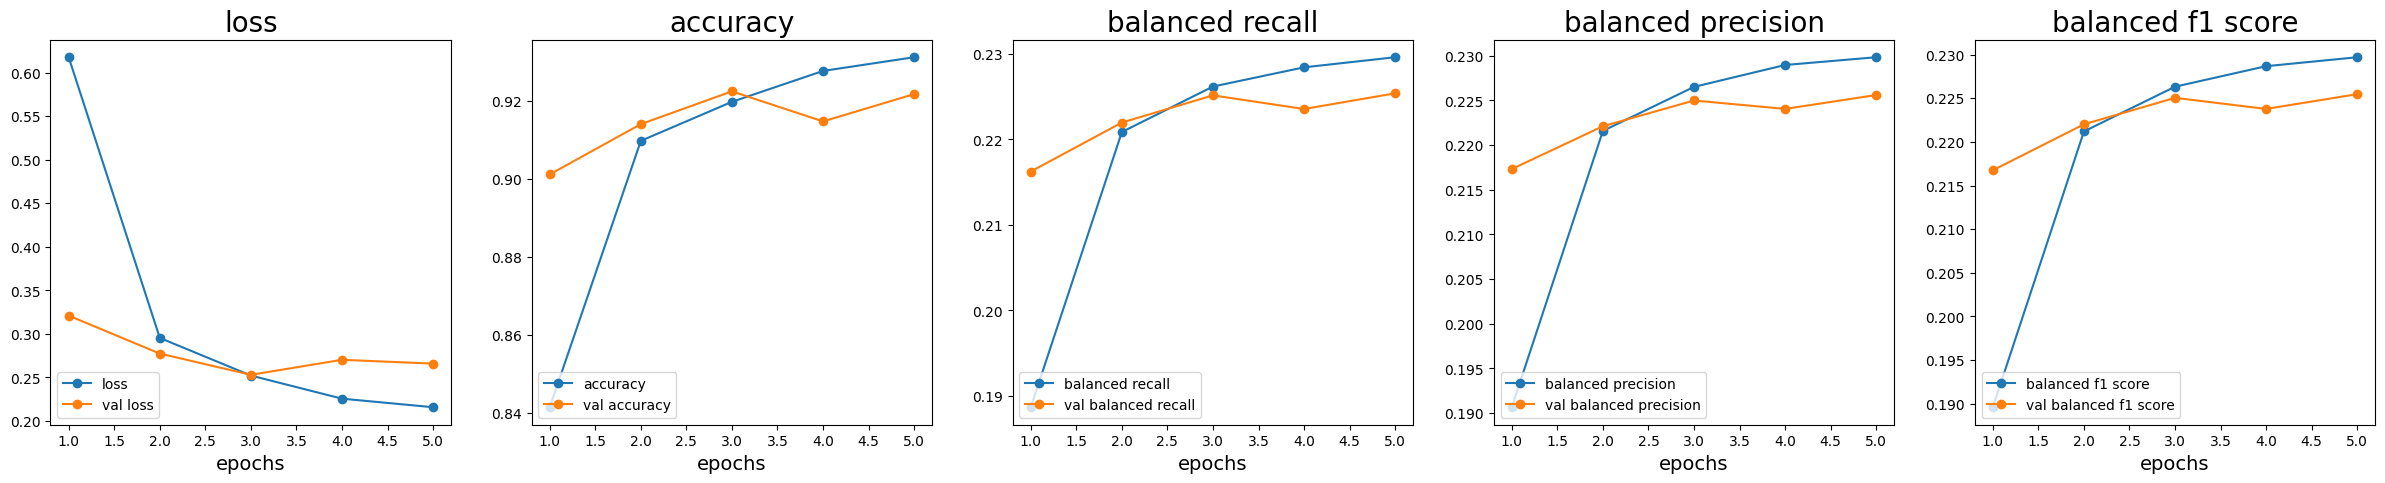

In [ ]:
x = list(range(1, n_epochs+1)) # -4 due to early stopping
metric_list = list(model_fit.history.keys())
num_metrics = int(len(metric_list)/2)

fig, ax = plt.subplots(nrows=1, ncols=num_metrics, figsize=(30, 5))

for i in range(0, num_metrics):
  ax[i].plot(x, model_fit.history[metric_list[i]], marker="o", label=metric_list[i].replace("_", " "))
  ax[i].plot(x, model_fit.history[metric_list[i+num_metrics]], marker="o", label=metric_list[i+num_metrics].replace("_", " "))
  ax[i].set_xlabel("epochs",fontsize=14)
  ax[i].set_title(metric_list[i].replace("_", " "),fontsize=20)
  ax[i].legend(loc="lower left")

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /roo

In [ ]:
from huggingface_hub import push_to_hub_keras

In [ ]:
push_to_hub_keras(model,"AmitTewari/LegalPro-BERT")

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

fingerprint.pb:   0%|          | 0.00/56.0 [00:00<?, ?B/s]

saved_model.pb:   0%|          | 0.00/14.0M [00:00<?, ?B/s]

'https://huggingface.co/AmitTewari/LegalPro-BERT/tree/main/'

In [ ]:
def predict_class(clause):
  '''predict class of input text
  Args:
    - reviews (list of strings)
  Output:
    - class (list of int)
  '''
  return [np.argmax(pred) for pred in model.predict(clause)]

In [ ]:
y_pred = predict_class(x_test)

313/313 [==============================] - 107s 334ms/step


In [ ]:
y_test_unencoded = np.argmax(y_test, axis=-1)
y_test_unencoded

array([35, 75, 55, ..., 26, 23, 81])

In [ ]:
print(classification_report(y_test_unencoded, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96        88
           1       0.61      0.81      0.70        48
           2       0.93      0.94      0.93       224
           3       0.88      1.00      0.94        23
           4       0.69      0.21      0.32        53
           5       0.60      0.81      0.69        26
           6       0.94      0.98      0.96        47
           7       0.98      0.93      0.96       195
           8       0.00      0.00      0.00         4
           9       0.79      0.79      0.79        62
          10       0.86      0.89      0.87        90
          11       1.00      0.99      1.00       112
          12       0.96      0.99      0.98        81
          13       0.83      0.71      0.76       126
          14       1.00      1.00      1.00         2
          15       1.00      1.00      1.00        70
          16       1.00      0.98      0.99        63
          17       0.98    

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<ipython-input-60-0584953ff862>:2: RuntimeWarning: invalid value encountered in true_divide
  cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


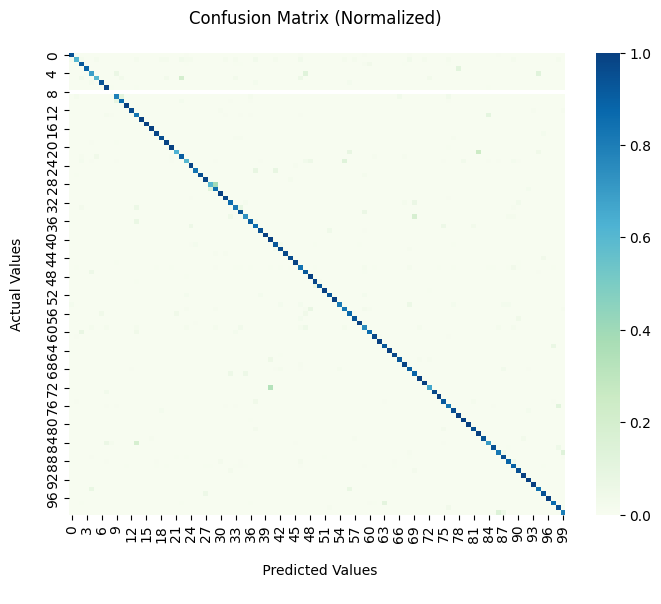

In [ ]:
cm = confusion_matrix(y_pred,y_test_unencoded)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(8,6))
fx = sns.heatmap(cmn, fmt='.2f', cmap= 'GnBu') # cmap="GnBu"
fx.set_title('Confusion Matrix (Normalized) \n');
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n');

In [ ]:
# Runtime termination code
from google.colab import runtime
runtime.unassign()